<img align="right" src="../additional_data/banner.png" style="width:1100px;">

# Cloud-Filtered Custom Mosaics

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Prerequisites**: Users should review the [Cloud Statistics](DCAL_Cloud_Statistics.ipynb) notebook for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses.









### Background

A mosaic is a composite image created by combining the most appropriate pixels from a collection of source images. A common use case is to create cloud-free images for applications that are not time-dependent. 

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

* Median = midpoint of spectral data
* Mean = arithmetic mean of pixels in time series
* Geomedian = Australian median product with improved spectral consistency
* Most-Recent = most-recent clear pixel
* Max-NDVI = maximum vegetation response

Contributed by CEOS SEO/AMA (https://www.opendatacube.org/dcal)



## Preliminary steps

In [8]:
# Supress Warning
import warnings
warnings.filterwarnings('ignore')
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'bavaria_one', config = '/home/datacube/.datacube.conf')
import sys

### Available extents

We've listed the available ingested data that you can explore in the Bavarian Data Cube (BYDC). The latitude, longitude and time ranges correspond to the boundaries of the state of Bavaria. You'll be able to explore sub-samples of these cube, by providing the platform, product and resolution information.


#### Sentinel 2A/B Bavaria
Platform: `'Sentinel_2'` <br>
Product: `'s2_l2a_bavaria'` <br>
Latitude:  `(498179, 856141)` <br>
Longitude: `(5233737, 5602806)` <br>
Time: `('2015-07-04', '2020-09-30')` <br>
Resolution: `(-10, 10)`
## .
## .
## .
## tbc



### Set product information

You can change the values in this cell to specify the product you wish to analyse.

In [2]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a product and platform
platform = "SENTINEL_2"
product = 's2_l2a_bavaria'
resolution = (-10, 10)
crs = 'EPSG:25832'

### Set extent information

You can change the values in this cell to specify the extent of the data cube you wish to analyse.

You should select a sub-sample from one of the four data cubes listed above. When subsampling, keep in mind that:
* Your latitude and longitude bounds should be within the extents given.
* Your area should be small to keep load times reasonable (less than 10 km x 10 km ).
* Your time period should be within the extents given.

You should format the variables as:
* `latitude = (min_latitude, max_latitude)`
* `longitude = (min_longitude, max_longitude)`
* `time_extents = (min_time, max_time)`, where each time has the format: `'YYYY-MM-DD'`.

In [3]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>
# Select a sub-region to analyse
longitude  = (5507000, 5509000)
latitude = (562000, 564000)

time_extents = ('2018-05-01', '2018-06-01')

### View the region before loading

The next cells will allow you to view the area you'll be analysing by displaying a red bounding box on an interactive map. You can change the extents in the previous cell and rerun the `display_map()` command to see the resulting bounding box.
Further, you will see how to define a polygon, apply a coordinate system to the polygon to use it as geodataframe and reproject the new geodataframe. Finally, we can tak a look on the two polygons.

In [4]:
# For display on a webmap we need to change the regional projection (i.e. EPSG:25832) to WGS84 based degree lat/lon
# load needed functions
from shapely.geometry import Polygon
from pyproj import CRS
# load needed package
import geopandas as gpd
# define a polygon extent with defined extents
y_min = longitude[0]
y_max = longitude[1]
x_min = latitude[0]
x_max = latitude[1]
lat_point_list = [y_min, y_max, y_max, y_min, y_min]
lon_point_list = [x_min, x_min, x_max, x_max, x_min]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

In [5]:
# Define a projection
cosy = CRS('EPSG:25832')
# build a geopandas dataframe with EPSG:2583
polygon = gpd.GeoDataFrame(index=[0], crs=cosy, geometry=[polygon_geom])
# reproject "polygon" to EPSG:
polygon_wgs = polygon.to_crs('EPSG:4326')

In [6]:
# And show the polygon bounds
print('Polygon with EPSG:28532','\n')
print(polygon.bounds,'\n')
print('Polygon with EPSG:4326','\n')        
print(polygon_wgs.bounds,'\n')

Polygon with EPSG:28532 

       minx       miny      maxx       maxy
0  562000.0  5507000.0  564000.0  5509000.0 

Polygon with EPSG:4326 

       minx       miny      maxx       maxy
0  9.859996  49.712103  9.888062  49.730299 



In [10]:
# Display the map
sys.path.append('/datacube/data_cube_notebooks/datacube/utils')
from data_cube_utilities.dc_display_map import display_map
 
map_longitude = (polygon_wgs.bounds.minx[0],polygon_wgs.bounds.maxx[0])
map_latitude = (polygon_wgs.bounds.miny[0], polygon_wgs.bounds.maxy[0])

display_map(map_latitude, map_longitude)


## Load the dataset and the required spectral bands and scl parameters

The data is loaded by passing the product and area information to the `dc.load()` function. As a part of this load, we also specify the measurements we want in the form of the Landsat bands. We also include the pixel quality assurance band.

The load can take up to 30 seconds, so please be patient.

In [9]:
# Load the data
# 1. Function for show loading progress
from odc.ui import with_ui_cbk
# 2. Load data
dataset = dc.load(
    product=product,
    x=(x_min, x_max),
    y=(y_min, y_max),
    #time=('2019-06-01','2019-07-01'),
    time=time_extents,
    crs=crs,
    resolution=resolution,
    #measurements=['red','green','blue','nir','scl'],
    progress_cbk=with_ui_cbk(),
)

It is often useful to print the loaded data to check the dimensions and data variables

When looking at the dimensions, the numbers for latitude and longitude correspond to the number of pixels in each dimension and the number for time corresponds to the number of time steps. 

In [10]:
# Displays an overview of the loaded data
dataset

<xarray.Dataset>
Dimensions:          (time: 13, x: 200, y: 200)
Coordinates:
  * time             (time) datetime64[ns] 2018-05-02T10:24:34 ... 2018-06-01...
  * y                (y) float64 5.509e+06 5.509e+06 ... 5.507e+06 5.507e+06
  * x                (x) float64 5.62e+05 5.62e+05 ... 5.64e+05 5.64e+05
    spatial_ref      int32 25832
Data variables:
    coastal_aerosol  (time, y, x) int16 6892 6892 6762 6762 ... 911 911 911 911
    blue             (time, y, x) int16 4784 4748 4724 4743 ... 1028 1166 1001
    green            (time, y, x) int16 4812 4787 4833 4798 ... 1130 1384 1384
    red              (time, y, x) int16 4801 4771 4783 4784 ... 838 1018 1218
    red_edge1        (time, y, x) int16 5384 5384 5381 5381 ... 1276 1606 1606
    red_edge2        (time, y, x) int16 5944 5944 5955 5955 ... 3447 3838 3838
    red_edge3        (time, y, x) int16 6248 6248 6211 6211 ... 4316 4697 4697
    nir              (time, y, x) int16 6195 6142 6134 6188 ... 4620 4672 4652
    narrow_nir       (time, y, x) int16 6279 6279 6272 6272 ... 4536 4967 4967
    water_vapour     (time, y, x) int16 3983 3983 3909 3909 ... 4901 4901 4901
    swir1            (time, y, x) int16 2983 2983 2985 2985 ... 1944 2181 2181
    swir2            (time, y, x) int16 2934 2934 2915 2915 ... 1069 1246 1246
    scl              (time, y, x) uint8 9 9 9 9 9 9 9 9 ... 10 10 10 10 10 10 10
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

## Masking out clouds
#### Loading needed functions, till the we finalize our package.

In [11]:
#from s2fn import s2_unpack_scl
import xarray as xr
from xarray.ufuncs import logical_and as xr_and
from xarray.ufuncs import logical_or  as xr_or
import numpy as np

def s2_scl_clean_mask(dataset, cover_types=['vegetation', 'vegetation']):# here, masking everything instead of scl 'vegetation'
    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    for i, cover_type in enumerate(cover_types):
        cover_type_clean_mask = s2_unpack_scl(dataset.scl, cover_type)
        clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
    return clean_mask

def unpack_s2bits(s2_scl_endcoding, data_array, cover_type):
    boolean_mask = np.isin(data_array.values, s2_scl_endcoding[cover_type]) 
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)

def s2_unpack_scl(data_array , cover_type):
    s2_scl_endcoding = dict(no_data                       =[0],
                                saturated_or_defective        =[1],
                                dark_area_pixels              =[2],
                                cloud_shadows                 =[3],
                                vegetation                    =[4],
                                not_vegetated                 =[5],
                                water                         =[6],
                                unclassified                  =[7],
                                cloud_medium_probability      =[8],
                                cloud_high_probability        =[9],
                                thin_cirrus                   =[10],
                                snow                          =[11],
                                cloud                         =[3,8,9,10],
                                cloud_free                    =[4,5,6]
                               )
    return unpack_s2bits(s2_scl_endcoding, data_array, cover_type)



We have defined a function to mask clouds based on the sen2cor scene classification. The function returns an 'xarray.DataArray' object containing the mask. This can then be passed to the `where()` function, which masks the data.



In [13]:
cloud_mask = s2_scl_clean_mask(dataset)

cleaned_dataset = dataset.where(cloud_mask)

In [36]:
cleaned_dataset

<xarray.Dataset>
Dimensions:      (time: 13, x: 200, y: 200)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-02T10:24:34 ... 2018-06-01T10:...
  * y            (y) float64 5.509e+06 5.509e+06 ... 5.507e+06 5.507e+06
  * x            (x) float64 5.62e+05 5.62e+05 5.62e+05 ... 5.64e+05 5.64e+05
    spatial_ref  int32 25832
Data variables:
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    scl          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:25832
    grid_mapping:  spatial_ref

## Generating mosaics

### Median Mosaic

This method masks clouds from imagery using the median of the cloud-free pixels in the time series.

In [11]:
from data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

NameError: name 'cleaned_dataset' is not defined

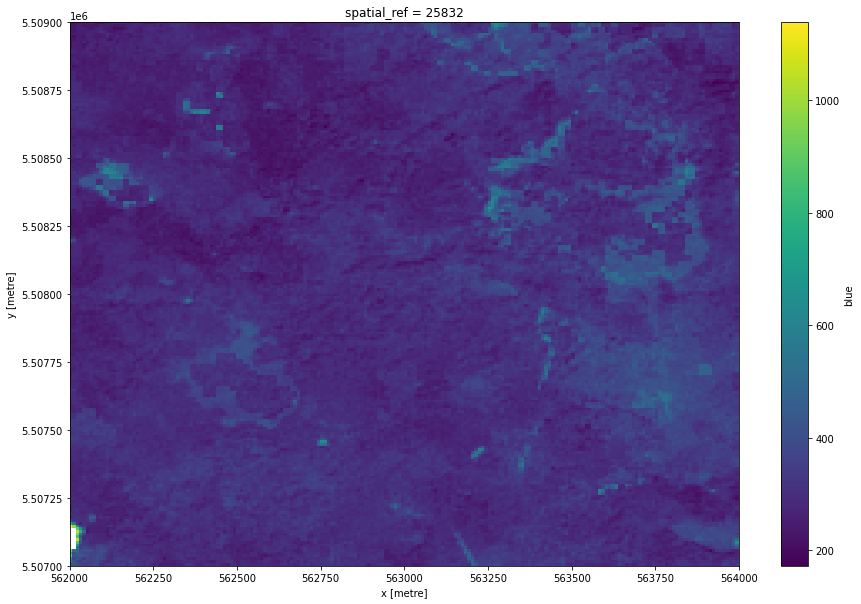

In [15]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
#
median_composite.blue.plot(size=10) # for red band
# ...


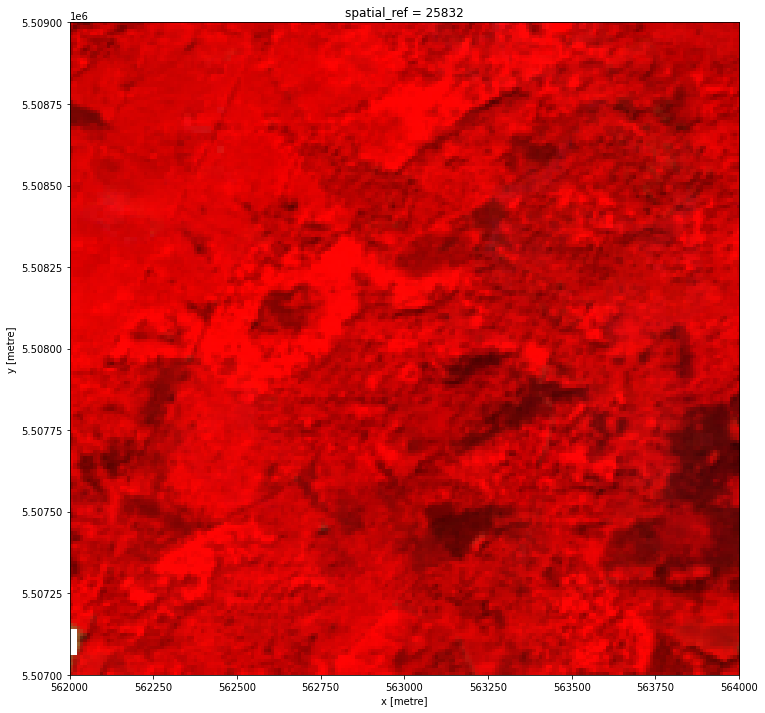

In [18]:
# Plot three-band-composite
# Also try changing the percentile stretch
rgb(median_composite, bands=['nir','red','blue'], percentile_stretch = (0.01,0.99), size = 12)
# False color
#rgb(median_composite, bands=['nir', 'red', 'green'], percentile_stretch = (0.01,0.99), size = 12)

### Mean Mosaic

This method masks clouds from imagery using the mean of the cloud-free pixels in the time series.

In [19]:
from utils.data_cube_utilities.dc_mosaic import create_mean_mosaic
mean_composite = create_mean_mosaic(cleaned_dataset, cloud_mask)

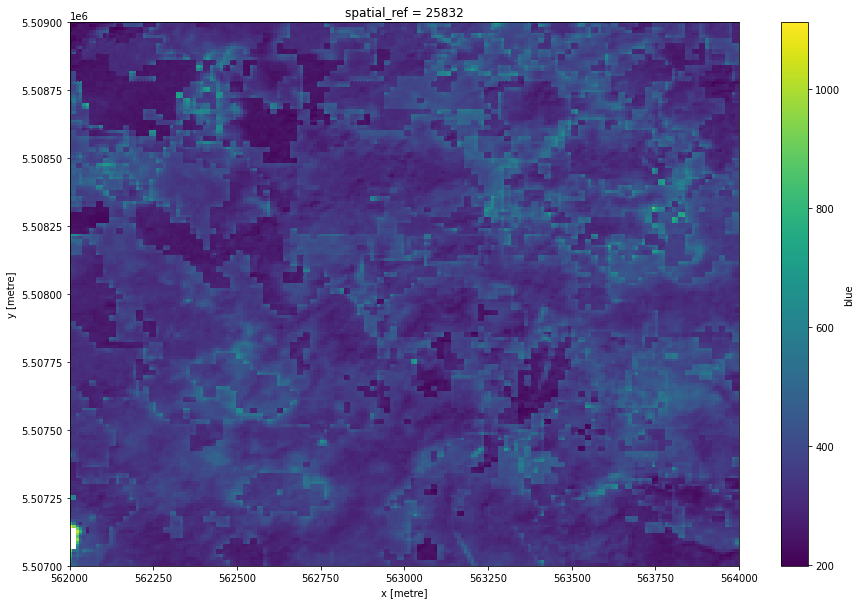

In [20]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
#median_composite.nir.plot(size=10) # for NIR band
#
mean_composite.blue.plot(size=10) # for red band
# ...


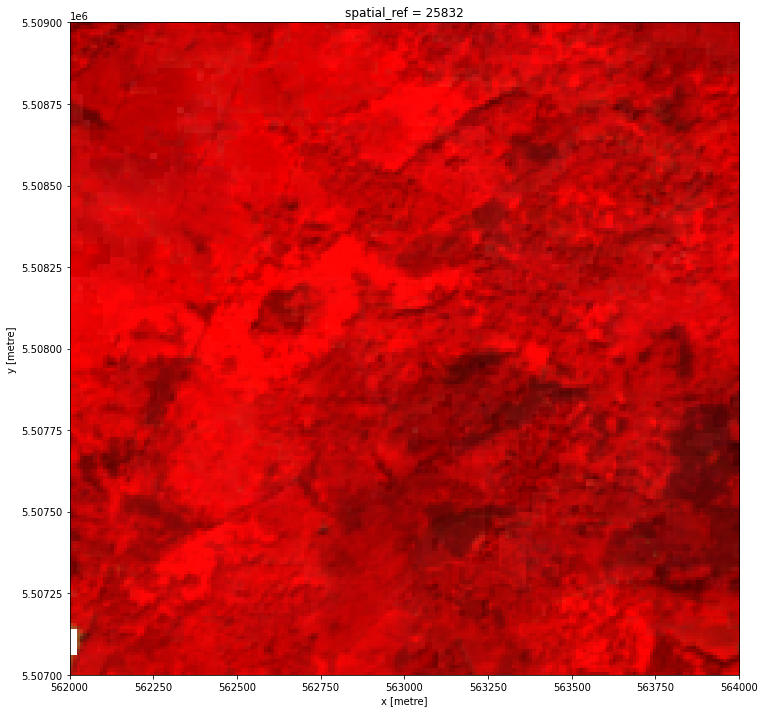

In [21]:
# Plot three-band-composite
# Also try changing the percentile stretch
rgb(mean_composite, bands=['nir','red','blue'], percentile_stretch = (0.01,0.99), size = 12)
# False color
#rgb(mean_composite, bands=['nir', 'red', 'green'], percentile_stretch = (0.01,0.99), size = 12)

### GeoMedian Mosaic
This method masks clouds from imagery using the median of the cloud-free pixels in the time series while maintaining the spectral band relationships. This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 

For more information, see the following paper: [High-Dimensional Pixel Composites from Earth Observation Time Series](https://ieeexplore.ieee.org/document/8004469), by Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

In [24]:
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
geomedian_composite = create_hdmedians_multiple_band_mosaic(cleaned_dataset, cloud_mask)

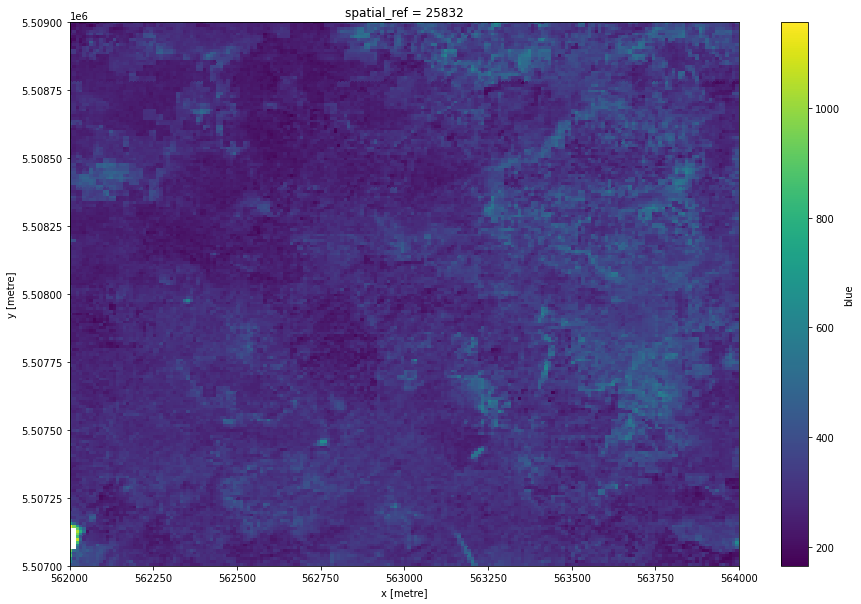

In [25]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
geomedian_composite.blue.plot(size=10) # for NIR band
#
#geomedian_composite.blue.plot(size=10) # for blue band
# ...
# TODO geomedian function switched x/y

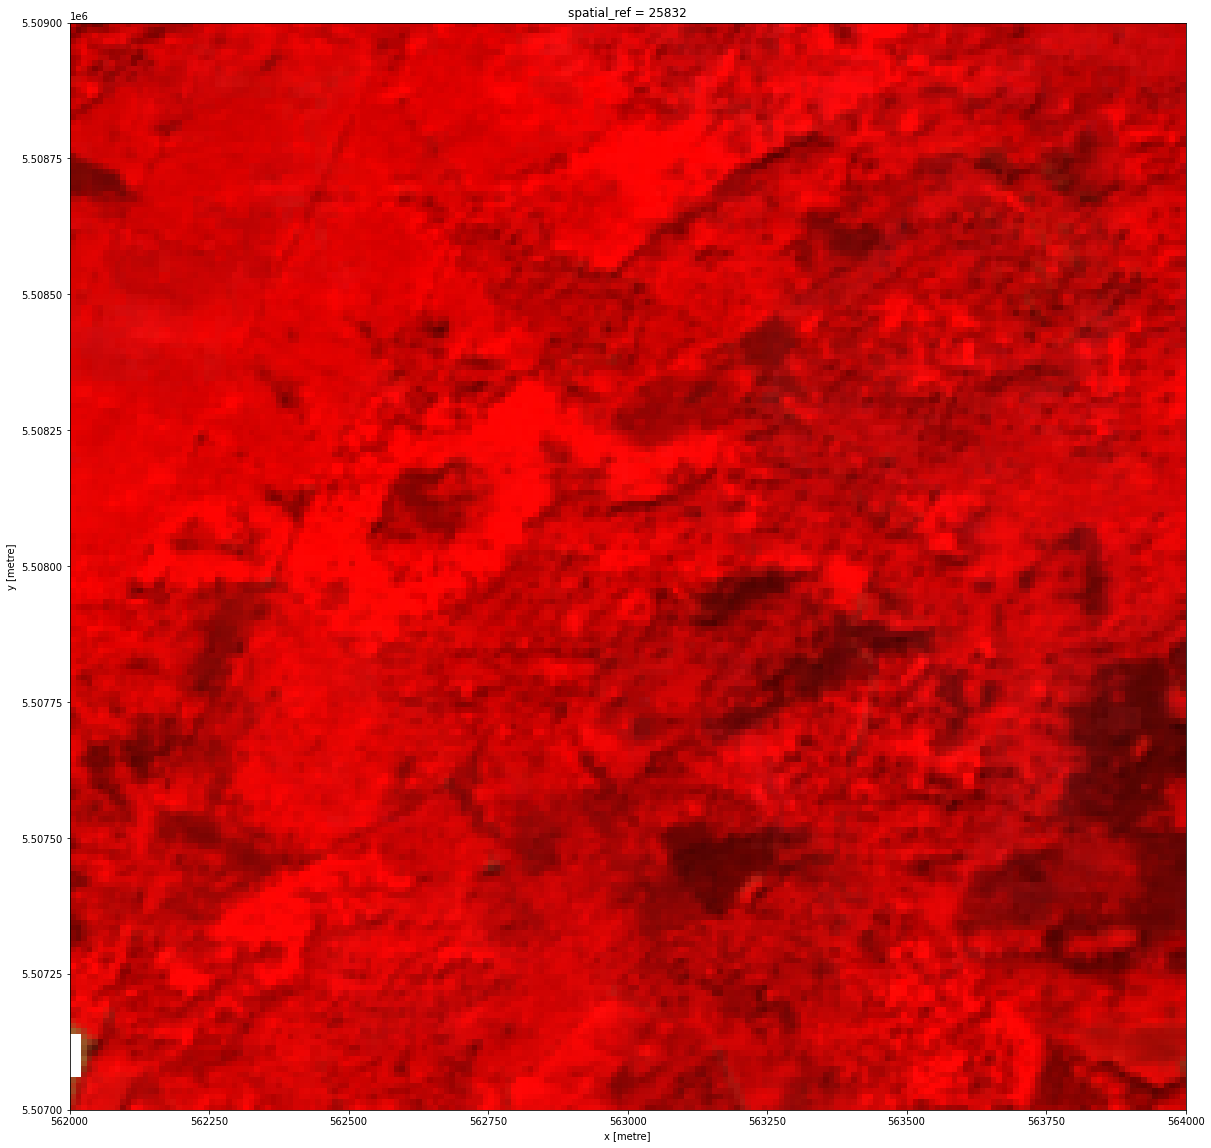

In [27]:
# Plot three-band-composite
# Also try changing the percentile stretch
#rgb(median_composite, bands=['red','green','blue'], percentile_stretch = (0.001,0.999), size = 12)
# False color
rgb(geomedian_composite, bands=['nir','red','blue'], percentile_stretch = (0.01,0.99), size = 20)

### Most Recent Mosaic
This method masks clouds from imagery using the most recent cloud-free pixels in the time series.

In [31]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic
most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)

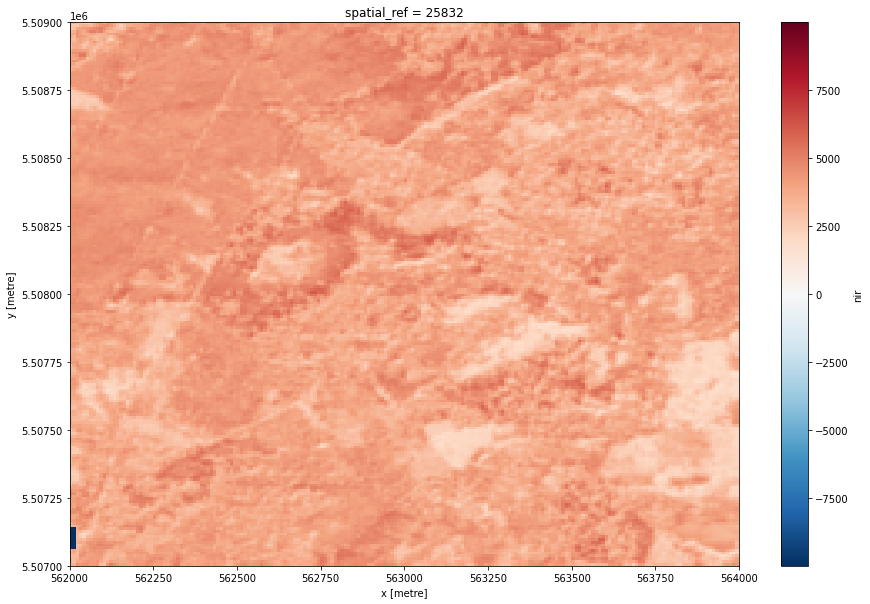

In [35]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
most_recent_composite.nir.plot(size=10) # for NIR band
#
#most_recent_composite.blue.plot(size=10) # for blue band
# ...

### Max NDVI Mosaic
This method masks clouds from imagery using the Max NDVI (also works for Min NDVI) across time for cloud-free pixels in the time series. 

In [37]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)

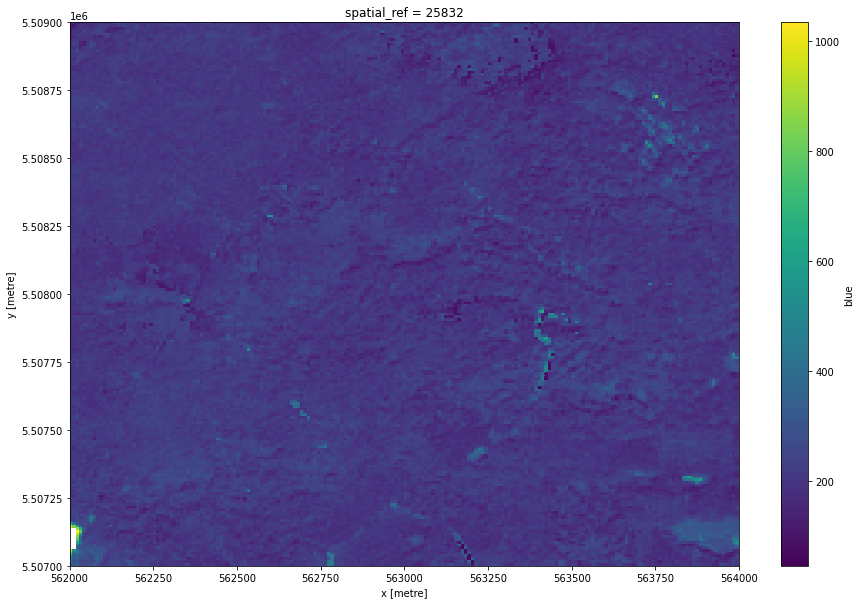

In [39]:
# Plot single bands, with <dataset_name>.<band_name>.plot(size=<integer>)
max_ndvi_composite.blue.plot(size=10) # for NIR band
#
#max_ndvi_composite.blue.plot(size=10) # for blue band
# ...

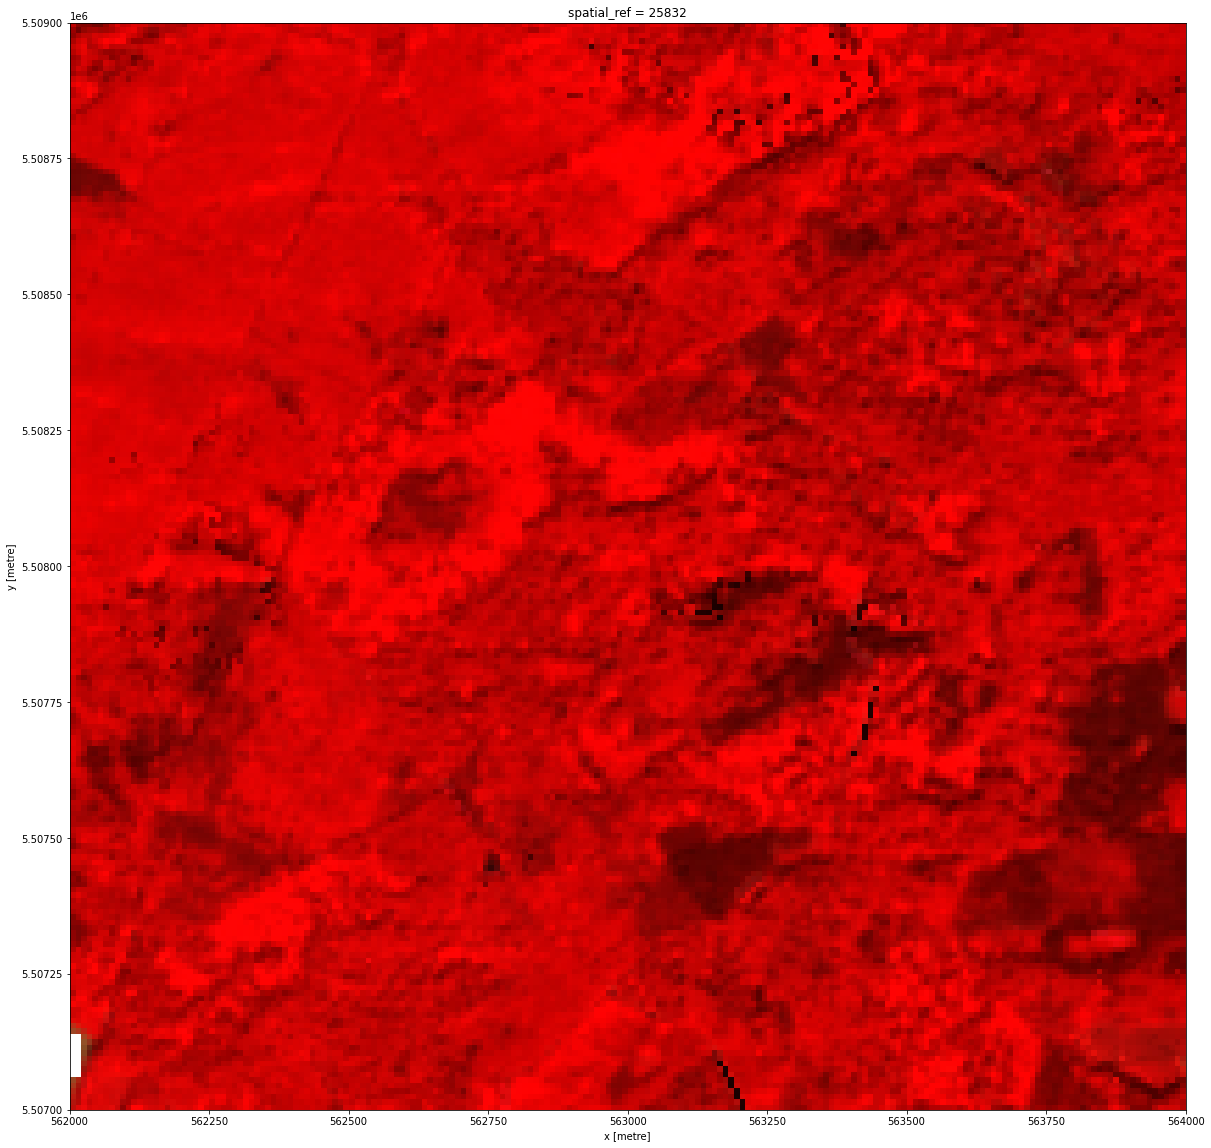

In [41]:
# Plot three-band-composite
# Also try changing the percentile stretch
#rgb(median_composite, bands=['red','green','blue'], percentile_stretch = (0.001,0.999), size = 12)
# False color
rgb(max_ndvi_composite, bands=['nir','red','blue'], percentile_stretch = (0.01,0.99), size = 20)

## Export to PNG
This can be done by using the rgb() function

Exporting image to median_composite.png


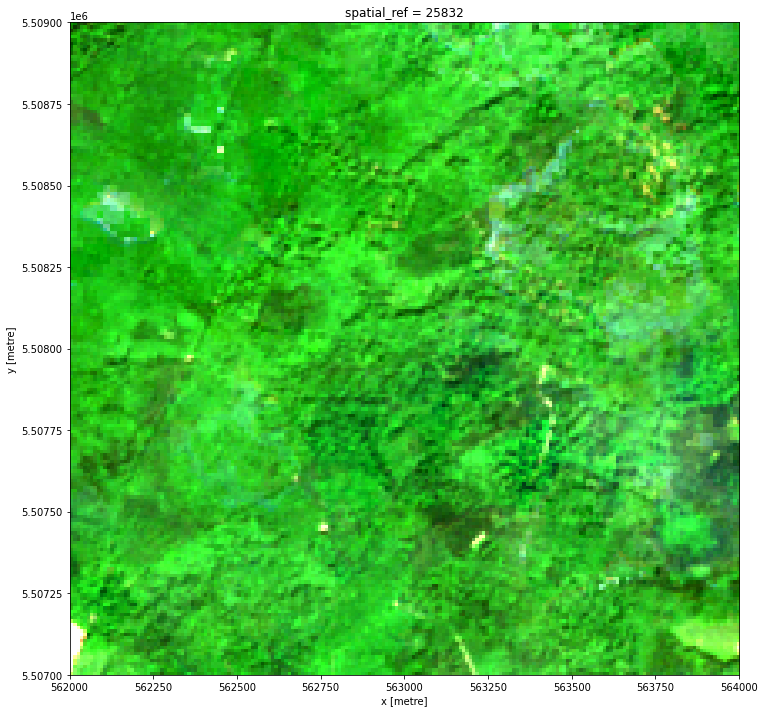

In [42]:
# CHANGE HERE >>>>>>>>>>>>>
# Extract RGB using 
rgb(median_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12, 
   savefig_path='median_composite.png')
#rgb(mean_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12, 
#   savefig_path='mean_composite.png')
#rgb(geomedian_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12, 
#   savefig_path='geomedian_composite.png')
#rgb(most_recent_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12, 
#   savefig_path='most_recent_composite.png')
#rgb(max_ndvi_composite, bands=['red','green','blue'], percentile_stretch = (0.01,0.99), size = 12, 
#   savefig_path='max_ndvi_composite.png')